# Doubling

(64,)
40
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29. 30. 31.]
 [32. 33. 34. 35. 36. 37. 38. 39.]
 [23. 24. 25. 26. 18. 19. 20. 21.]
 [18. 19. 20. 21. 13. 14. 15. 16.]
 [13. 14. 15. 16.  8.  9. 10. 11.]]


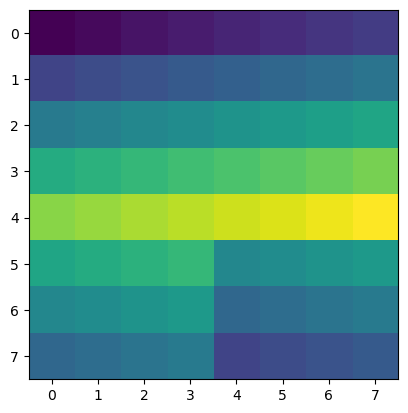

In [1]:
import numpy as np
ntheta = 5
npix = 40
nphi = npix//ntheta
synth1D = np.arange((ntheta * nphi))
doubling1D = np.zeros(((2 * ntheta - 2)* nphi))
import matplotlib.pyplot as plt
print(doubling1D.shape)

nphihalf = nphi // 2
print(ntheta*nphi)
for i in range(ntheta):
    for j in range(nphi):
        doubling1D[i * nphi + j] = synth1D[i * nphi + j]
for i in range(ntheta, 2 * ntheta-2, 1):
    for j in range(0, nphihalf):
        doubling1D[i * nphi + j] = np.copy(synth1D[2*ntheta-2 - i * (ntheta) + j])
for i in range(ntheta, 2 * ntheta-2, 1):
    for j in range(nphihalf, nphi):
        doubling1D[i * nphi + j] = synth1D[ntheta - i * (ntheta)-2 + j - nphihalf]


# print(synth1D)

np.array(doubling1D)

# del synth1D, doubling1D
plt.imshow(doubling1D.reshape(2*ntheta - 2, nphi))

print(doubling1D.reshape(2*ntheta - 2, nphi))

In [135]:
print(doubling1D_py)

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29. 30. 31.]
 [32. 33. 34. 35. 36. 37. 38. 39.]
 [28. 29. 30. 31. 24. 25. 26. 27.]
 [20. 21. 22. 23. 16. 17. 18. 19.]
 [12. 13. 14. 15.  8.  9. 10. 11.]]


In [83]:
doubling1D_py = np.zeros((2 * ntheta-2, nphi))
print(doubling1D_py.flatten().shape)
synth1D_py = np.copy(synth1D.reshape(ntheta, nphi))
print(synth1D_py.shape, doubling1D_py[:ntheta, :].shape)

nphihalf = nphi//2
doubling1D_py[:ntheta, :] = synth1D_py
doubling1D_py[ntheta:, :nphihalf] = doubling1D_py[ntheta-2:0:-1, nphihalf:]
doubling1D_py[ntheta:, nphihalf:] = doubling1D_py[ntheta-2:0:-1, :nphihalf]

doubling1D_py.flatten()

(64,)
(5, 8) (5, 8)


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 28., 29., 30., 31., 24., 25., 26., 27., 20., 21., 22., 23.,
       16., 17., 18., 19., 12., 13., 14., 15.,  8.,  9., 10., 11.])

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29. 30. 31.]
 [32. 33. 34. 35. 36. 37. 38. 39.]
 [28. 29. 30. 31. 24. 25. 26. 27.]
 [20. 21. 22. 23. 16. 17. 18. 19.]
 [12. 13. 14. 15.  8.  9. 10. 11.]]


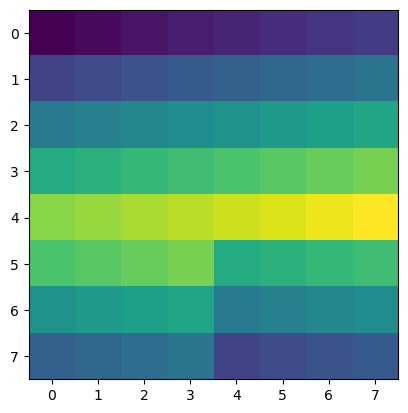

# integration spin1 - pointing

In [1]:
import cupy as cp
import numpy as np
import shtns
import matplotlib.pyplot as plt
from pysht.c.podo_interface import Cpointing_ptrs, Cpointing_cparr, Cpointing_1Dto1D



def input_values(nring):
    npix = int(nring+1)*2*(nring+1)
    thetas = cp.linspace(1, np.pi, nring, dtype=cp.float64)
    phi0 = cp.zeros(nring, dtype=cp.float64)
    ringstarts = cp.linspace(0, npix-npix//nring, nring, dtype=np.uint64)
    nphis = cp.array([npix/nring for a in np.arange(nring)], dtype=np.uint64)
    del nring, npix
    return locals()

test_cases = [ 
              lmax for lmax in [2**n-1 for n in np.arange(8, 9)]
              ]
for test_case in test_cases:
    cGPU = shtns.sht(int(test_case), int(test_case))
    cGPU.set_grid(flags=shtns.SHT_ALLOW_GPU + shtns.SHT_THETA_CONTIGUOUS, nlat=int(test_case+1), nphi=int(2*(test_case+1)))
    
    npix = cGPU.nphi*cGPU.nlat

    alm_random = np.array([np.random.randn(cGPU.nlm) + 1j*np.random.randn(cGPU.nlm)], dtype=np.complex128)
    alm = cp.array(alm_random)

    print("shape of alm: ", alm.shape)
    print("shape of alm_random: ", alm_random.shape)

    out_spin1theta = cp.empty(shape=(1,cGPU.nphi,cGPU.nlat), dtype=cp.float64)
    out_spin1phi = cp.empty(shape=(1,cGPU.nphi,cGPU.nlat), dtype=cp.float64)
    cGPU.cu_SHsph_to_spat(alm.data.ptr, out_spin1theta.data.ptr, out_spin1phi.data.ptr)
    
    input_value = input_values(test_case)
    out_pointingtheta = cp.zeros(npix, dtype=cp.float64)
    out_pointingphi = cp.zeros(npix, dtype=cp.float64)
    Cpointing_1Dto1D(**input_value, spin1_theta=out_spin1theta.flatten(), spin1_phi=out_spin1phi.flatten(), out_ptheta=out_pointingtheta, out_pphi=out_pointingphi)
    
    from ducc0.misc import get_deflected_angles
    def2d = np.array([out_spin1theta.get()[0].flatten(), out_spin1phi.get()[0].flatten()])
    tht_phip_gamma = get_deflected_angles(theta=input_value['thetas'].get(), phi0=input_value['phi0'].get(), nphi=input_value['nphis'].get(), ringstart=input_value['ringstarts'].get(), deflect=def2d.T,
                                                      calc_rotation=False, nthreads=10)
    # self.assertEqual(np.mean(out_pt.get()), np.mean(out_pt.get()))

[SHTns 3.6.6] built Apr  4 2024, 19:17:02, id: v3.6.6-6-gd00ef3e*,avx512,ishioka,openmp,cuda
Could not import skcuda.fft
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
shape of alm:  (1, 32896)
shape of alm_random:  (1, 32896)


In [2]:
print("shape of out_spin1theta: ", out_spin1theta.flatten().shape)
print("shape of out_spin1phi: ", out_spin1phi.flatten().shape)
print("Shape of def2d: ", def2d.shape)

shape of out_spin1theta:  (131072,)
shape of out_spin1phi:  (131072,)
Shape of def2d:  (2, 131072)


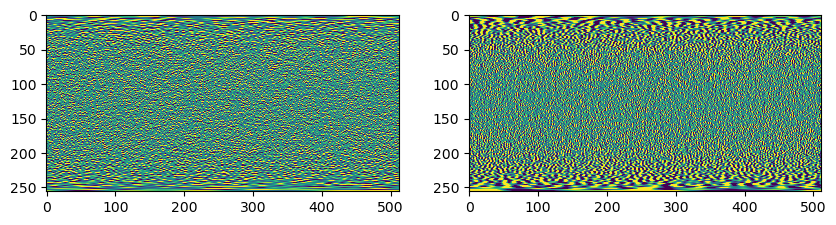

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].imshow(out_spin1theta.get()[0].T, vmin=-1e4, vmax=1e4)
ax[1].imshow(out_spin1phi.get()[0].T, vmin=-1e4, vmax=1e4)

In [4]:
print("Shape of out_pointingtheta: ", out_pointingtheta.shape)
print("Shape of out_pointingphi: ", out_pointingphi.shape)
print("Shape nlat, nphi: ", cGPU.nlat, cGPU.nphi)
print("Shape of tht_phip_gamma: ", tht_phip_gamma.shape)

Shape of out_pointingtheta:  (131072,)
Shape of out_pointingphi:  (131072,)
Shape nlat, nphi:  256 512
Shape of tht_phip_gamma:  (131072, 2)


In [5]:
# while np.max(out_pointingphi)>2*np.pi:
#     out_pointingphi = np.where(out_pointingphi>2*np.pi, out_pointingphi-2*np.pi, out_pointingphi)

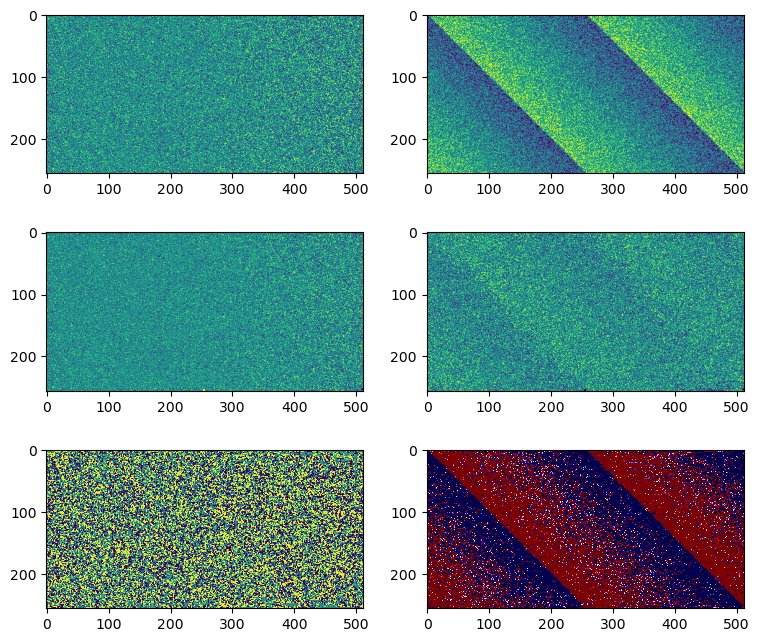

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2, figsize=(9,8))
ax[0,0].imshow(out_pointingtheta.get().reshape(512,-1).T, vmin=0, vmax=np.pi)
ax[0,1].imshow(out_pointingphi.get().reshape(512,-1).T, vmin=0, vmax=2*np.pi)
ax[1,0].imshow(tht_phip_gamma[:,0].reshape(512,-1).T, vmin=0, vmax=np.pi)
ax[1,1].imshow(tht_phip_gamma[:,1].reshape(512,-1).T, vmin=0, vmax=2*np.pi)
ax[2,0].imshow((out_pointingtheta.get()-tht_phip_gamma[:,0]).reshape(512,-1).T, vmin=-1e-1, vmax=1e-1)
ax[2,1].imshow((out_pointingphi.get()-tht_phip_gamma[:,1]).reshape(512,-1).T, vmin=-1e-1, vmax=1e-1, cmap='seismic')

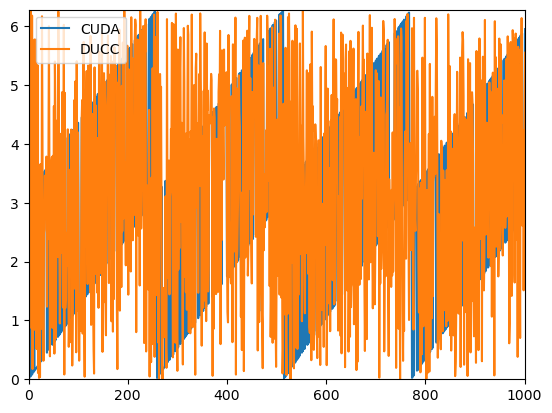

(0.0, 2.0)

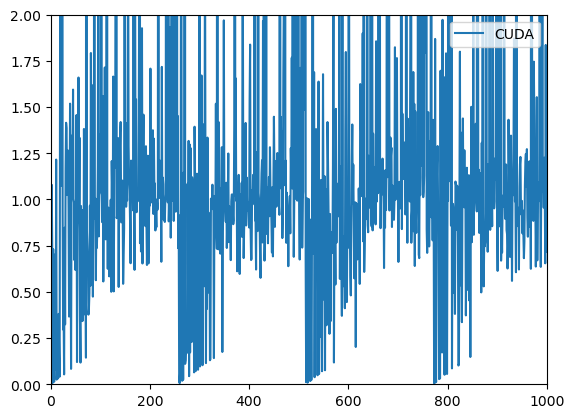

In [15]:
plt.plot(out_pointingphi.get(), label='CUDA')
plt.plot(tht_phip_gamma[:,1], label='DUCC')
plt.legend()
plt.xlim(0,1000)
plt.ylim(0,2*np.pi)

plt.show()
plt.plot(out_pointingphi.get()/tht_phip_gamma[:,1], label='CUDA')
plt.legend()
plt.xlim(0,1000)
plt.ylim(0,2)

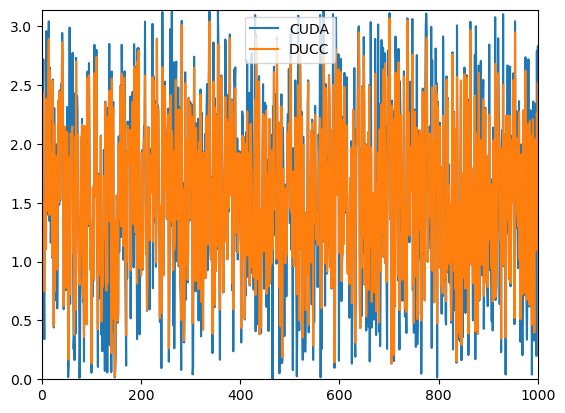

(0.0, 1000.0)

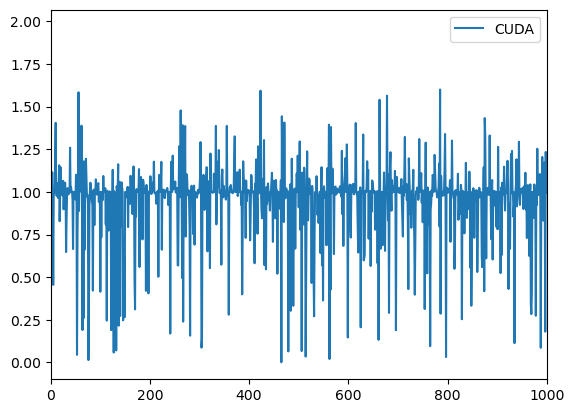

In [12]:
plt.plot(out_pointingtheta.get(), label='CUDA')
plt.plot(tht_phip_gamma[:,0], label='DUCC')
plt.legend()
plt.xlim(0,1000)
plt.ylim(0,np.pi)
plt.show()
plt.plot(out_pointingtheta.get()/tht_phip_gamma[:,0], label='CUDA')
plt.legend()
plt.xlim(0,1000)

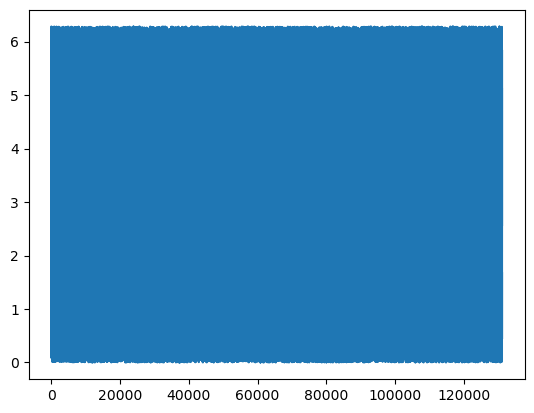

In [13]:
tht_phip_gamma[:,1]

array([5.10649771, 5.85551785, 5.89690523, ..., 2.23232625, 0.68377281,
       1.66870855])

In [14]:
out_pointingphi.get()

array([0.00000000e+00, 1.22238047e-02, 2.44475533e-02, ...,
       3.14059267e+00, 7.12573224e-04, 3.14444202e+00])